<a href="https://colab.research.google.com/github/raviyk/recommendersys/blob/movielens/Session_embed_2_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [20]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-08-28 11:01:04--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.80.48, 104.31.81.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2020-08-28 11:01:04 (13.7 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [21]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [22]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [23]:
df = df.drop(['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4'], axis = 1)

In [24]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
df.columns = ['labels', 'data']

In [26]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values#convert to numpy array

In [28]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [29]:
Y

array([0, 0, 1, ..., 0, 0, 0])

In [30]:
#split the data 
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [52]:
df_test = df_test.reset_index()

In [31]:
type(df_test)

pandas.core.series.Series

In [53]:
type(df_test[Ytest==1])

pandas.core.frame.DataFrame

In [54]:
df_test[Ytest==1].index

Int64Index([   4,    5,    7,   15,   34,   53,   61,   65,   70,   71,
            ...
            1787, 1791, 1805, 1811, 1813, 1818, 1823, 1829, 1831, 1834],
           dtype='int64', length=250)

In [51]:
df_test.shape

(1839,)

In [58]:
df_test.iloc[5]

index                                                 1443
data     Free 1st week entry 2 TEXTPOD 4 a chance 2 win...
Name: 5, dtype: object

In [40]:
#df_test.iloc(5368)
print(df_test[df_test.index.isin([5368])])

Series([], Name: data, dtype: object)


In [59]:
#Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train) #Fit only on the train dataset
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [60]:
#get word index mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens' % V)

Found 7178 unique tokens


In [61]:
#pad seq so that we have a NxT matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor: ', data_train.shape)
T = data_train.shape[1] #If test dataset contains longer sentences, it will be truncated
print(T)

Shape of data train tensor:  (3733, 162)
162


In [51]:
#pad seq so that we have a NxT matrix
data_test = pad_sequences(sequences_test)
print('Shape of data test tensor: ', data_test.shape)

Shape of data test tensor:  (1839, 121)


In [58]:
tokenizer.sequences_to_texts(data_test)

['of does he have any cash yet',
 'love you aathi love u lot',
 'it is then okay',
 'forwarded from please call immediately as there is an urgent message waiting for you',
 'you have won a nokia 7250i this is what you get when you win our free auction to take part send nokia to 86021 now hg suite342 2lands row w1jhl 16',
 'urgent you have won a 1 week free membership in our å£100 000 prize txt the word claim to no t c www net pobox',
 'dear got train and mine lower',
 "i've told him that i've it that should i re order it",
 's if we have one good partnership going we will take lead',
 'what i mean is do they come chase you out when its over or is it you can watch as many movies as you want',
 'have a good evening ttyl',
 "hows my favourite person today r u workin hard couldn't sleep again last nite nearly u at 4 30",
 "sorry i'll call later in meeting",
 'dunno y u ask me',
 'okie',
 'i know you are serving i mean what are you doing now',
 'dear how is chechi did you talk to her',
 'ur

In [52]:
#Create the model 

#Set embedding dimention
D = 20

#Hidden state dimentionality
M = 15

i = Input(shape=(T,))
x = Embedding(V+1, D)(i) #to index, size of array must be '+1'
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x) #works well for long term dependency
x = Dense(1, activation='sigmoid')(x) #spam classification is binary
#test using bidirectiona LSTM
model = Model(i, x)


In [38]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 20)           145660    
_________________________________________________________________
lstm (LSTM)                  (None, 189, 15)           2160      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 147,836
Trainable params: 147,836
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    epochs=10,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 8s 70ms/step - loss: 0.4795 - accuracy: 0.8473 - val_loss: 0.3846 - val_accuracy: 0.8711
Epoch 2/10
117/117 [==============================] - 8s 66ms/step - loss: 0.3984 - accuracy: 0.8634 - val_loss: 0.3833 - val_accuracy: 0.8711
Epoch 3/10
117/117 [==============================] - 8s 66ms/step - loss: 0.3964 - accuracy: 0.8634 - val_loss: 0.3803 - val_accuracy: 0.8711
Epoch 4/10
117/117 [==============================] - 8s 69ms/step - loss: 0.3832 - accuracy: 0.8634 - val_loss: 0.3541 - val_accuracy: 0.8711
Epoch 5/10
117/117 [==============================] - 8s 71ms/step - loss: 0.2812 - accuracy: 0.8795 - val_loss: 0.1676 - val_accuracy: 0.9706
Epoch 6/10
117/117 [==============================] - 8s 70ms/step - loss: 0.1018 - accuracy: 0.9879 - val_loss: 0.0839 - val_accuracy: 0.9875
Epoch 7/10
117/117 [==============================] - 8s 70ms/step - loss: 0.0443 - accuracy: 0.9957 - val_loss: 0.0627 - va

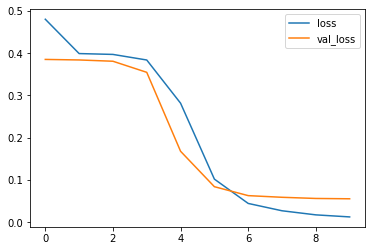

In [43]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

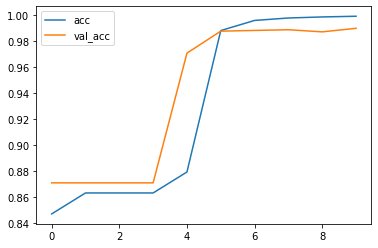

In [45]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [47]:
data_test[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  16, 127,   7,
       112,  22,  15, 147,  16, 127,  22], dtype=int32)

In [ ]:
model.predict()